In [41]:
import json
import plotly.graph_objs as go
import numpy as np
from numpy.linalg import inv, det
import cv2
import matplotlib.pyplot as plt

In [2]:
# Specify the path to the JSON file
file_path = '/mnt/ssd_daten/kuh/output/reconstruction/sfm_data.json'

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Print the loaded data
print(data)

{'sfm_data_version': '0.3', 'root_path': '/dataset/', 'views': [{'key': 0, 'value': {'polymorphic_id': 1073741824, 'ptr_wrapper': {'id': 2147483649, 'data': {'local_path': '', 'filename': 'camera01.jpg', 'width': 4608, 'height': 2592, 'id_view': 0, 'id_intrinsic': 0, 'id_pose': 0}}}}, {'key': 13, 'value': {'polymorphic_id': 1073741824, 'ptr_wrapper': {'id': 2147483650, 'data': {'local_path': '', 'filename': 'camera14.jpg', 'width': 4608, 'height': 2592, 'id_view': 13, 'id_intrinsic': 0, 'id_pose': 13}}}}, {'key': 1, 'value': {'polymorphic_id': 1073741824, 'ptr_wrapper': {'id': 2147483651, 'data': {'local_path': '', 'filename': 'camera02.jpg', 'width': 4608, 'height': 2592, 'id_view': 1, 'id_intrinsic': 0, 'id_pose': 1}}}}, {'key': 14, 'value': {'polymorphic_id': 1073741824, 'ptr_wrapper': {'id': 2147483652, 'data': {'local_path': '', 'filename': 'camera15.jpg', 'width': 4608, 'height': 2592, 'id_view': 14, 'id_intrinsic': 0, 'id_pose': 14}}}}, {'key': 15, 'value': {'polymorphic_id': 10

In [3]:
for i in data:
    print(i)

sfm_data_version
root_path
views
intrinsics
extrinsics
structure
control_points


In [4]:
bilder = ['/mnt/ssd_daten/kuh/'+i['value']['ptr_wrapper']['data']['filename'] for i in data['views']]

In [412]:
kamera = data['intrinsics'][0]['value']['ptr_wrapper']['data']
K = np.array([[kamera['focal_length'], 0, kamera['principal_point'][0]],
                [0, kamera['focal_length'], kamera['principal_point'][1]],
                [0, 0, 1]])
dist = np.r_[np.array(kamera['disto_k3']).T,np.zeros(2)]
K, dist

(array([[3.43250825e+03, 0.00000000e+00, 2.31161537e+03],
        [0.00000000e+00, 3.43250825e+03, 1.29760826e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([ 0.04327726,  0.00772511, -0.1162451 ,  0.        ,  0.        ]))

In [413]:
coords = np.array([i['value']['center'] for i in data['extrinsics']])
rot = np.array([i['value']['rotation'] for i in data['extrinsics']])

In [414]:
richtung = np.array([c + np.array([0,0,0.1]) @ r for c,r in zip(coords,rot)])


In [8]:
layout = go.Layout(
    scene=dict(
        aspectmode='data'
    ))

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=coords[:, 0], y=coords[:, 1],
                z=coords[:, 2], mode='markers', name='Original Points'),
    go.Scatter3d(x=richtung[:, 0], y=richtung[:, 1],
                 z=richtung[:, 2], mode='markers', name='Original Points')], layout=layout)

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

[2.31161537e+03 1.29760826e+03 1.00000000e+00]
[ 2.07053925e+03 -5.51847696e+04  1.00000000e+00]
[2.33802806e+03 1.72133033e+02 1.00000000e+00]
[3.68041272e+03 4.86721126e+02 1.00000000e+00]
[3.66664326e+03 1.81062204e+03 1.00000000e+00]
[ 5.52936453e+03 -3.80432702e+03  1.00000000e+00]
[5.43165099e+03 2.53776352e+03 1.00000000e+00]
[2.36100542e+03 1.36333837e+03 1.00000000e+00]
[ 1.97465578e+03 -2.39375851e+04  1.00000000e+00]
[ 8.62824834e+03 -1.05096890e+04  1.00000000e+00]
[ 5.46790563e+03 -5.30965100e+02  1.00000000e+00]
[ 3.73062288e+03 -1.44851987e+03  1.00000000e+00]
[-7.67050908e+02  2.02048578e+03  1.00000000e+00]
[-3.52864394e+03  4.35554212e+03  1.00000000e+00]
[ 2.32642821e+03 -1.25537443e+03  1.00000000e+00]
[1.01862097e+03 1.81936412e+03 1.00000000e+00]
[ 8.16907880e+03 -5.53346795e+03  1.00000000e+00]
[1.01126392e+03 3.97809530e+02 1.00000000e+00]
[-7.78389282e+02 -2.58669998e+03  1.00000000e+00]
[-7.51266225e+02 -1.00052912e+03  1.00000000e+00]
[-4.11644344e+03 -1.3595

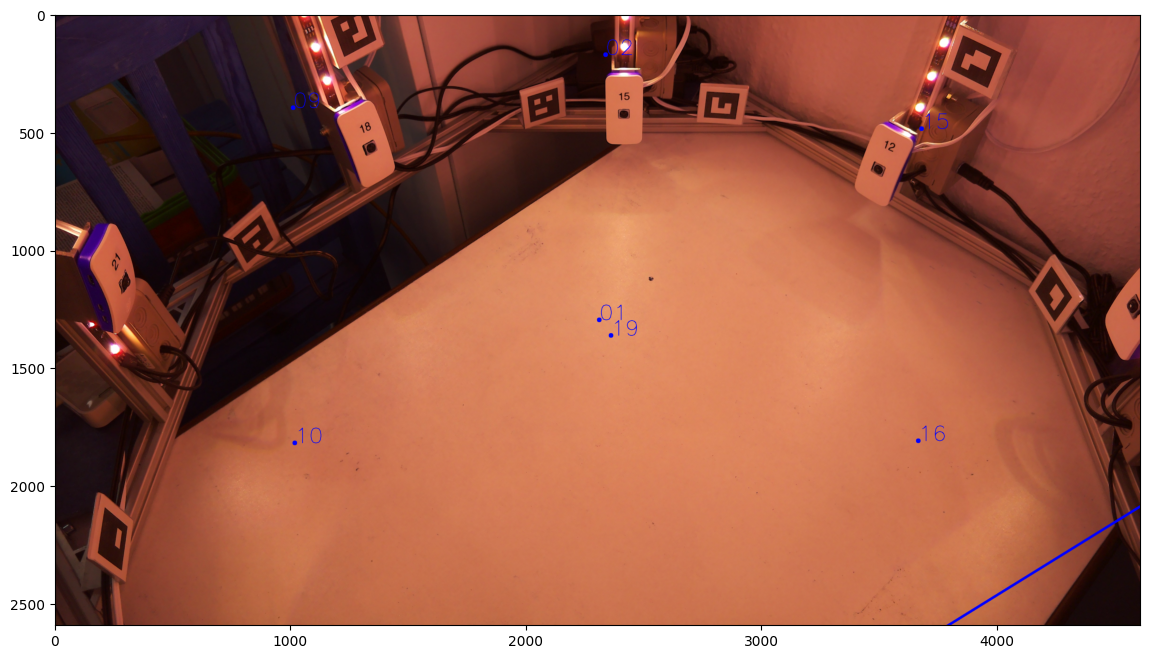

In [219]:
for bild, t, r,  in zip(bilder, coords, rot):
    #print(nr)
    imgCV = cv2.imread(bild)

    for p, b in zip(richtung, bilder):
        #r = -inv(r)
        #Rt = np.c_[r, r@t]
        #ph = np.r_[p, 1]
        #c = K@Rt@ph

        c=K@r@(p-t)
        c = c / c[2]
        print(c)
        try:
            cv2.circle(imgCV, (int(c[0]), int(
                c[1])), 10, (0, 0, 255), -1)
            cv2.putText(imgCV, str(b[-6:-4]), (int(c[0]), int(
                c[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
        except:
            pass
        #break
    cv2.drawFrameAxes(imgCV, K, np.zeros(5), r, t, 10, 10)
    plt.figure(figsize=(14, 11))
    plt.imshow(imgCV)
    plt.show()
    break

In [10]:
rot[0].T

array([[ 0.70825396,  0.01668525,  0.70576054],
       [ 0.12677993,  0.98046135, -0.15040743],
       [-0.69448051,  0.19600293,  0.69230027]])

In [11]:
np.linalg.inv(rot[0])

array([[ 0.70825396,  0.01668525,  0.70576054],
       [ 0.12677993,  0.98046135, -0.15040743],
       [-0.69448051,  0.19600293,  0.69230027]])

In [300]:
p = coords[0] #np.array([[0, 5, 0]], dtype=np.float64)  # 
R =  rot[0] #np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float64)  #
t = coords[0] #np.array([6,5,5], dtype=np.float64)


In [138]:
R = inv(R)
t = R@t

In [190]:

Rt = np.c_[R, t]
#Rt = np.r_[Rt, np.zeros((1, 4))]
#Rt[-1, -1] = 1
ph = np.r_[p, 1]

In [142]:
K[0,2] = -K[0,2]
K[1, 2] = -K[1,2]

In [143]:
K

array([[3.43250825e+03, 0.00000000e+00, 2.31161537e+03],
       [0.00000000e+00, 3.43250825e+03, 1.29760826e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [191]:
test = K@Rt@ph
test/test[2]

array([-3.45368376e+03,  1.46455542e+04,  1.00000000e+00])

In [189]:
cv2.projectPoints(ph[:3], R, t, K, None)

(array([[[-3453.68376059, 14645.55416539]]]),
 array([[ 9.13903899e+03,  2.37822816e+03, -1.20437146e+04,
          7.92970107e+03,  0.00000000e+00,  1.33188605e+04,
         -1.67961697e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.03446704e+05, -1.85614318e+06,
         -4.48388730e+04,  8.09564498e+04, -3.33047585e+07],
        [-2.84973495e+04, -3.24642976e+03,  1.10731220e+04,
          0.00000000e+00,  7.92970107e+03, -3.08361155e+04,
          0.00000000e+00,  3.88868574e+00,  0.00000000e+00,
          1.00000000e+00,  2.39502060e+05,  4.29738306e+06,
          1.65401395e+05, -4.48388730e+04,  7.71079012e+07]]))

In [151]:
t2 = Rt[:3, :3]@np.array([0, 0, 1])
t2

array([-0.69448051,  0.19600293,  0.69230027])

In [156]:
t2 = Rt@np.array([0, 0,1,1])

In [182]:
Rtinv = np.c_[R.T, -R.T@t]

In [172]:
inv(Rt[:3, :3])@(t2-Rt[:3, 3])

array([ 9.25100547e-17, -6.14320227e-17,  1.00000000e+00])

In [183]:
Rtinv@np.r_[t2,1]

array([ 0.00000000e+00, -1.11022302e-16,  1.00000000e+00])

In [195]:
t3 = -R.T@np.array([1, 2, 3]).T
t3

array([-2.85890606, -1.63648033, -1.77442618])

In [201]:
-R@t3

array([-1., -2., -3.])

In [209]:
K@R@(richtung[0]-t)

array([2.31161537e+02, 1.29760826e+02, 1.00000000e-01])

## Versuch der Berechnung der Rotation

In [337]:
soll = pd.DataFrame([[1, 2304, 1296,1],
                 [21, 300, 1140,1],
                 [18, 1338, 565,1],
                 [15, 2417, 419,1],
                 [12, 3502, 656,1],
                 [9, 4579, 1238,1]], columns=['camera','x_img','y_img','z_img']).astype({'camera':int}).set_index('camera')
soll

x_img  y_img  z_img
camera                     
1        2304   1296      1
21        300   1140      1
18       1338    565      1
15       2417    419      1
12       3502    656      1
9        4579   1238      1

In [349]:
soll[['x_img_norm', 'y_img_norm', 'z_img_norm']] = (
    inv(K)@soll[['x_img', 'y_img', 'z_img']].T).T
soll

x_img  y_img  z_img  x_img_norm  y_img_norm  z_img_norm
camera                                                         
1        2304   1296      1   -0.002219   -0.000469         1.0
21        300   1140      1   -0.586048   -0.045916         1.0
18       1338    565      1   -0.283645   -0.213432         1.0
15       2417    419      1    0.030702   -0.255967         1.0
12       3502    656      1    0.346797   -0.186921         1.0
9        4579   1238      1    0.660562   -0.017366         1.0

In [419]:
import pandas as pd
kombi = pd.DataFrame(np.c_[[int(bild[-6:-4]) for bild in bilder],coords], columns=['camera','x','y','z']).astype({'camera':int}).set_index('camera').join(soll).dropna()
kombi

x         y         z   x_img   y_img  z_img  x_img_norm  \
camera                                                                    
1      -0.674995  0.672013  0.395381  2304.0  1296.0    1.0   -0.002219   
15      0.968561  0.133223  0.974767  2417.0   419.0    1.0    0.030702   
18      0.688796  0.997722  0.452954  1338.0   565.0    1.0   -0.283645   
21      0.005071 -0.537170 -0.118399   300.0  1140.0    1.0   -0.586048   
12     -0.673023  0.583232  1.762576  3502.0   656.0    1.0    0.346797   
9       0.011928 -0.084034  1.914033  4579.0  1238.0    1.0    0.660562   

        y_img_norm  z_img_norm  
camera                          
1        -0.000469         1.0  
15       -0.255967         1.0  
18       -0.213432         1.0  
21       -0.045916         1.0  
12       -0.186921         1.0  
9        -0.017366         1.0

In [420]:
kombi[['dx','dy','dz']] = kombi[['x','y','z']]-t
kombi

x         y         z   x_img   y_img  z_img  x_img_norm  \
camera                                                                    
1      -0.674995  0.672013  0.395381  2304.0  1296.0    1.0   -0.002219   
15      0.968561  0.133223  0.974767  2417.0   419.0    1.0    0.030702   
18      0.688796  0.997722  0.452954  1338.0   565.0    1.0   -0.283645   
21      0.005071 -0.537170 -0.118399   300.0  1140.0    1.0   -0.586048   
12     -0.673023  0.583232  1.762576  3502.0   656.0    1.0    0.346797   
9       0.011928 -0.084034  1.914033  4579.0  1238.0    1.0    0.660562   

        y_img_norm  z_img_norm        dx        dy        dz  
camera                                                        
1        -0.000469         1.0  0.000000  0.000000  0.000000  
15       -0.255967         1.0  1.643556 -0.538790  0.579386  
18       -0.213432         1.0  1.363790  0.325709  0.057573  
21       -0.045916         1.0  0.680066 -1.209183 -0.513780  
12       -0.186921         1.0  0.001972 -0.088781  1.367195  
9        -0.017366         1.0  0.686923 -0.756047  1.518652

In [352]:
import numpy as np

# Define the two point groups as numpy arrays
point_group1 = soll[['x_img_norm', 'y_img_norm', 'z_img_norm']]
point_group2 = kombi[['dx', 'dy', 'dz']]

# Compute the centroid of each point group
centroid1 = np.mean(point_group1, axis=0)
centroid2 = np.mean(point_group2, axis=0)

# Center the point groups around their centroids
centered_group1 = point_group1 - centroid1
centered_group2 = point_group2 - centroid2

# Compute the covariance matrix
covariance_matrix = np.dot(centered_group1.T, centered_group2)

# Perform Singular Value Decomposition (SVD)
U, _, Vt = np.linalg.svd(covariance_matrix)

# Compute the rotation matrix
rotation_matrix = np.dot(U, Vt)

# Print the rotation matrix
print(rotation_matrix)

[[-0.73222923 -0.2300385   0.64103248]
 [ 0.52113059  0.41673639  0.74481789]
 [-0.43847835  0.87943906 -0.18526647]]


In [353]:
det(rotation_matrix)

0.9999999999999998

In [354]:
kombi[['dx_rot', 'dy_rot', 'dz_rot']] = (K@inv(rotation_matrix)@kombi[['dx', 'dy', 'dz']].values.T).T
kombi['dx_rot'] = kombi['dx_rot'] / kombi['dz_rot']
kombi['dy_rot'] = kombi['dy_rot'] / kombi['dz_rot']
kombi['dz_rot'] = kombi['dz_rot'] / kombi['dz_rot']
kombi

x         y         z   x_img   y_img  z_img  x_img_norm  \
camera                                                                    
1      -0.674995  0.672013  0.395381  2304.0  1296.0    1.0   -0.002219   
15      0.968561  0.133223  0.974767  2417.0   419.0    1.0    0.030702   
18      0.688796  0.997722  0.452954  1338.0   565.0    1.0   -0.283645   
21      0.005071 -0.537170 -0.118399   300.0  1140.0    1.0   -0.586048   
12     -0.673023  0.583232  1.762576  3502.0   656.0    1.0    0.346797   
9       0.011928 -0.084034  1.914033  4579.0  1238.0    1.0    0.660562   

        y_img_norm  z_img_norm        dx        dy        dz        dx_rot  \
camera                                                                       
1        -0.000469         1.0  0.000000  0.000000  0.000000           NaN   
15       -0.255967         1.0  1.643556 -0.538790  0.579386  -8637.818549   
18       -0.213432         1.0  1.363790  0.325709  0.057573   -338.771433   
21       -0.045916         1.0  0.680066 -1.209183 -0.513780  10698.707137   
12       -0.186921         1.0  0.001972 -0.088781  1.367195   9294.032402   
9        -0.017366         1.0  0.686923 -0.756047  1.518652  15585.961383   

              dy_rot  dz_rot  
camera                        
1                NaN     NaN  
15        711.299045     1.0  
18        902.407475     1.0  
21      11629.672742     1.0  
12     -11270.308294     1.0  
9       -6027.803707     1.0

In [357]:
kombi[['dx', 'dy', 'dz']]-(inv(rotation_matrix)@soll[['x_img_norm', 'y_img_norm', 'z_img_norm']].values.T).T

dx        dy        dz
camera                              
1       0.437098 -0.879754  0.187038
15      1.676841 -1.533908  1.174528
18      1.705801 -0.530034  0.583634
21      1.274417 -1.974889 -0.157546
12      0.791796 -0.810547  1.469376
9       1.618134 -1.476294  1.293411

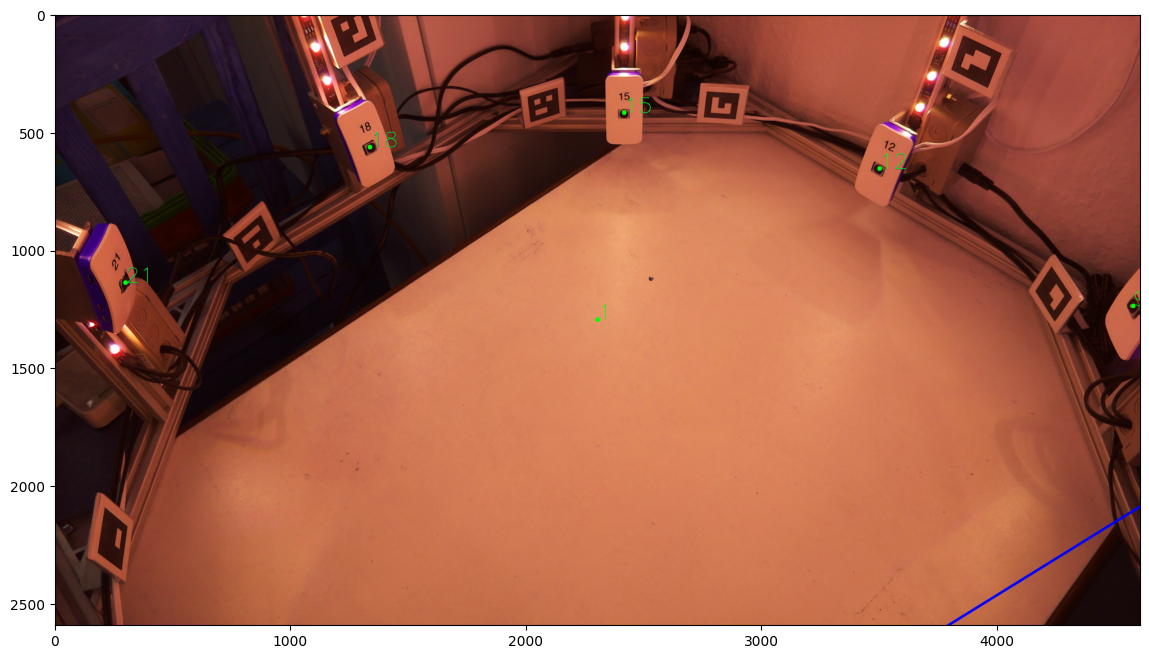

In [257]:

# print(nr)
imgCV = cv2.imread(bilder[0])

for c, b, test in zip(soll[:, 1:], soll[:, 0], test2.T):

    try:
        cv2.circle(imgCV, (int(c[0]), int(
            c[1])), 10, (0, 0, 255), -1)
        cv2.putText(imgCV, str(b), (int(c[0]), int(
            c[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
    except:
        pass

    d = K@test
    try:
        cv2.circle(imgCV, (int(d[0]), int(
            d[1])), 10, (0, 255, 0), -1)
        cv2.putText(imgCV, str(b), (int(d[0]), int(
            d[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)
    except:
        pass
    # break
cv2.drawFrameAxes(imgCV, K, np.zeros(5), r, t, 10, 10)
plt.figure(figsize=(14, 11))
plt.imshow(imgCV)
plt.show()

In [417]:
soll[['x_img', 'y_img']].values[1:]*1.

array([[ 300., 1140.],
       [1338.,  565.],
       [2417.,  419.],
       [3502.,  656.],
       [4579., 1238.]])

In [448]:
_, rvec, tvec,_=cv2.solvePnPRansac(kombi[['x', 'y', 'z']].values[1:]*1., kombi[['x_img', 'y_img']].values[1:]*1., K, None)

In [449]:
cv2.projectPoints(kombi[['x', 'y', 'z']].values, rvec, tvec, K, dist)[0][:,0,:]

array([[-1933.279957  , -1810.29815177],
       [ 2452.55650104,   811.17600884],
       [ 1399.12089321,  -963.41600198],
       [  229.46424848,  1920.3374391 ],
       [ 5286.07085949, -2131.88207435],
       [ 4247.13107195,  1493.67741109]])

[-1699.02910136 -1433.55533189]
[2468.23553875  902.97029051]
[1443.61769303 -800.24954132]
[ 279.29979099 1988.22599751]
[ 5073.99193382 -1579.18300311]
[4214.44592274 1612.79838623]


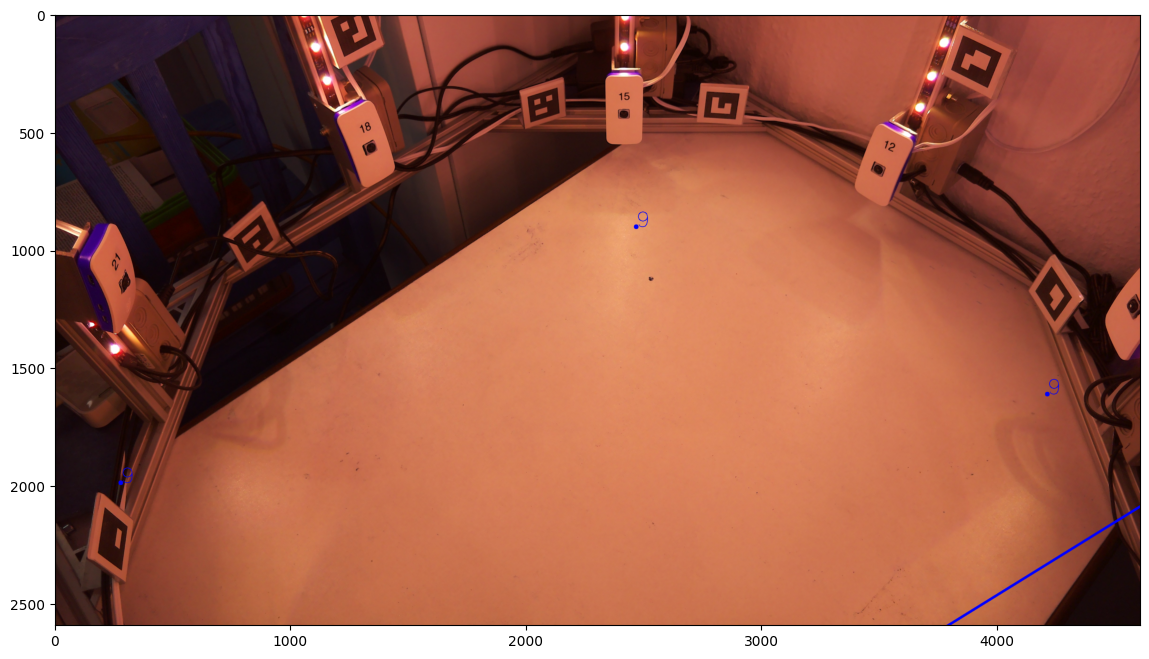

In [424]:
imgCV = cv2.imread(bilder[0])

for x,y,z in kombi[['x', 'y', 'z']].values:

    c = cv2.projectPoints(np.array([[x, y, z]]), rvec, tvec, K, dist)[
        0][0, 0, :]
    print(c)
    try:
        cv2.circle(imgCV, (int(c[0]), int(
            c[1])), 10, (0, 0, 255), -1)
        cv2.putText(imgCV, str(b), (int(c[0]), int(
            c[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
    except:
        pass
cv2.drawFrameAxes(imgCV, K, np.zeros(5), r, t, 10, 10)
plt.figure(figsize=(14, 11))
plt.imshow(imgCV)
plt.show()